# Overview
Vasha Dutell  
Rotation Project
Bruno Olshausen Lab  
Vision Science - UC Berkeley  

This document details the notes on the eye movement simulation project, begun by Vasha as a rotation project in the Bruno Olshausen in Fall, 2015. This is an extention to Alex Anderson's eye movement project on processing of information by the fovea, which includes data from Austin Roorda's lab, of subjects fixating on the 4-directional E, and their eye movements tracked by the AOSLO (Adaptive Optics Scanning Laser Ophthalmoscope). In creating simulated data of this task used for Alex's pipeline, the current alghrithm used for modeling eye movement is a simple diffusion model. This is an oversimplification of eye movement, and the simulated eye-movement data is easily differentiated from the real recordings. Specific differences include a sense of 'momentum' in the real recordings, which the time-step based diffusion does not retain.

# Goals
"Create a model of fixational eye movement that is 'more realistic'."  

The primary goal here is to create a simulator of fixational eye movement that resembles more closely what is seen in real data. We need to be specific here - 'real data' is what is recoreded from subjects head-mounted in the AOSLO, with a 4-directional E shape being projected on their retina while their eye position is being recorded - certainly not a 'real world' scenero. And we we must also take into account that the AOSLO does not  record eye torsion ('roll' - pupil position stays horizontal and vertical position and 'rolls' - this eye movement happens when the head is moved side to side touching eitehr ear to shoulders). The recordings have an X and Y position only (check this to make sure). Though according to Listing's law, torsion does not exist in a situation where the head is motionless.

The goal of creating a 'realistic model' may or may not mean incorporating simulation of the biologically realistic effectors of eye movement such as the 6 muscules in the eye that control eye movement/saccades. 

A first step towards this goal will be to analyze the recorded data with methods such as PCA/ICA to interpreate what components exist, and how best a model might be made.

# Advice for first steps (from Alex)

Alex has layed out these steps for getting started on the project:

1. Contact Roorda/Kavitha about artifacts in data / what would the best dataset be. **(Done 8/31, meeting 9/2)** 

2. Read some papers general background:  
-- Martinez-Conde paper on eye movements in general **read 9/1**  
-- Rucci paper on benefits of eye movements  
-- Kuang, Rucci previous paper on eye movement benefits  
-- Rucci-Nature paper on eye movements  
-- Zhang/Roorda - AOSLO basics  **read 9/2**    
-- Olshausen - do we dejitter images?  **read 9/2**  
-- Gollisch-Meister - retina smarter that we believe  
-- Engbert - another model of eye movements  

3. Understood what I was doing with kalman filter, diffusion, velocity space diffusion
-- some code
-- write up about what i was doing there  

4. understand how to load the data from the roorda lab  
-- see analyze_aoslo_large.pdf
-- some details like converting from pixels to meters...
-- some days data is better than others  

5. Understand how modeling eye movements fits into what I am doing (ask me before going over) file = em_alg_latent_feat.pdf

# Notes

A general-understanding (wikipedia) and formal literature search including the articles recommended by Alex above was performed, as well as initial meetings with Kavitha Ratnam, from the Roorda Lab, to whom this data belongs. See notes in ipython notebook below:

Link to [Eye Movement Research Notes](Eye Movement Research Notes.ipynb)

# Pipeline

Pipeline for Analysis of the AOSLO data. Adapted from Alex's pipleline

## Load Dependencies

In [54]:
import numpy as np
import os
from scipy.io import loadmat
from scipy import math
from scipy.signal import butter, lfilter, freqz
from scipy.interpolate import interp1d
from pykalman import KalmanFilter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from filterpy.stats import plot_covariance_ellipse
import xlrd
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Load in AOSLO Data

In [55]:
dataDir = 'data'

from glob import glob
files = [y for x in os.walk(dataDir) for y in glob(os.path.join(x[0], '*.mat'))]
len(files)
#files

1040

### Examine Files
What exactly is in one of these files? Pull it into Matlab to take a look.    

Note: this is 20094L_020_cw_nostim_bandfilt_1920_hz_8199.mat.  

![fileContents1](img/fileContents1.png)
![fileContents2](img/fileContents2.png)

### Create EyeTrace class container to hold data

In [123]:
##make a class type containing the info for an eye trace

class EyeTrace:
    """A class to contain eye trace information"""
    def __init__(self, xlocs, ylocs, time, pixelscale, fname):
        
        ##define filename
        self.fname = fname
        
        ##define scaled time
        self.time = time - time[0]
        self.pixelscale = pixelscale
        
        ##define x and y attributes
        ##position
        self.x = np.subtract(xlocs, xlocs[0]) * pixelscale ## center at start and change from pixels to arcmins
        self.y = np.subtract(ylocs, ylocs[0]) * pixelscale ## center at start and change from pixels to arcmins
        ##velocity in arcmins/frame
        self.xv = np.concatenate([[np.subtract(self.x[1], self.x[0])], 
                                   np.subtract(self.x[1:], self.x[:-1])]
                                   ) * len(self.time) ##in seconds
        
        self.yv = np.concatenate([[np.subtract(self.y[1], self.y[0])],
                                   np.subtract(self.y[1:],  self.y[:-1])]
                                   ) * len(self.time) ##in seconds
        ##acceleration in arcmins/frame
        self.xa = np.concatenate([[np.subtract(self.xv[1], self.xv[0])], 
                                   np.subtract(self.xv[1:], self.xv[:-1])]
                                   ) * len(self.time) ##in seconds
        
        self.ya = np.concatenate([[np.subtract(self.yv[1], self.yv[0])],
                                   np.subtract(self.yv[1:],  self.yv[:-1])]
                                   ) * len(self.time) ##in seconds

        
        ##define attributes to hold original data after filtering
        self.xraw = self.x
        self.yraw = self.y
        self.xvraw = self.xv
        self.yvraw = self.yv
        self.xaraw = self.xa
        self.yaraw = self.ya
        self.timeraw = self.time

        ##info on the filter
        self.filterinfo = 'none'
        ##parameters
        self.kfivx = 0
        self.kfivy = 0
        self.kfiax = 0
        self.kfiay = 0
        self.kftvx = 0
        self.kftvy = 0
        self.kfov = 0
        self.kfdt = 0 
        ##covariances (we get this after filtering)
        self.xcov = []
        self.ycov = []
        self.xvcov = []
        self.yvcov = []

        
    def xs(self):
        return x
    def ys(self):
        return y
    def xvs(self):
        return xv
    def yvs(self):
        return yv
    def xas(self):
        return xa
    def yas(self):
        return ya
    def times(self):
        return time
    def pixelscales(self):
        return pixelscale
    def fname(self):
        return fname
    def filterinfo(self):
        return filterinfo
    def xraws(self):
        return xraw
    def yraws(self):
        return yraw
    def timeraws(self):
        return timeraw
    

## Subject Information

![SubjectInfo](img/subjinfo.png)

Each subject has a different scale conversion from pixels to arcmins. Need to apply this when we load each of our files into a container

### Loop through & Load 
Now load in each of our files, with each trial being initiated as a member of our EyeTrace class, and put in the vector trials

In [124]:
import re

trials = []
for fh in files:
    
    ##if it's 20053 it's the stabilize case so skip it.
    if(re.search('20053', fh)):
        0
    elif(re.search('20094', fh)):
        0
    else:
        nfile = loadmat(fh)
        xss = nfile['frameshifts_strips_spline'][:, 0] 
        yss = nfile['frameshifts_strips_spline'][:, 1] 
        tss = nfile['timeaxis_secs'][:,0] ##extract time axis (1920 frames)

        #print fh

        ##add scale info
        #if(re.search('20053', fh)):
        #    scale = 392.
        if(re.search('20073', fh)):
            scale = 420.
        elif(re.search('20014', fh)):
            scale = 489.
        #elif(re.search('20094', fh)):
        #    scale = 379.
        else:
            raise ValueError('No scale available for file',nfile)
        scalar = 1. / scale * 60. # Conversion from pixels to arcmins
        trial = EyeTrace(xss, yss, tss, scalar, fh)
        trials.append(trial)

len(trials)

476

## Filtering

### Make a filtered dataset to work with

In [125]:
import copy
ftrials = copy.deepcopy(trials)

### Check number of frames

In [126]:
print 'Number of frames:', len(trial.time)
print 'Muliple of 40:', len(trial.time)/40

Number of frames: 840
Muliple of 40: 21


Interesting. We have 840 frames in a 1 second timeseries. This corresponds to 840 Hz, or 21x the 40Hz rate we talked about. Here is my interpretation: 40Hz is the frame rate for update on the entire image, but the entire image is made up of 21 horizontal strips, each of which are updated at 40 Hz. However, every time we sample a new strip, we can compare that with the strip that was sampled last time, and update the x and y positions. A new strip is sampled at frequency 40*21=840 Hz. So we update our x and y positions at 840 Hz, hence this sampling rate.

44


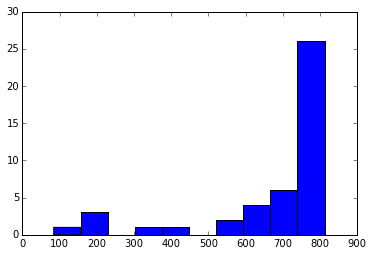

In [127]:
flens = []
for trial in trials:
    if(len(trial.x) < 840):
#       print trial.fname
#       print len(trial.x)
        #print trial.time[1:10]# * 853
        flens.append(len(trial.x))
plt.hist(flens)
print len(flens)

Not all trials run for a full second, aka not all are 840 frames. Need to remove these for consistency.

In [128]:
i=0
while i < len(ftrials):
    if(len(ftrials[i].x) < 840):
        del ftrials[i]
        i = i-1
    i+=1

print len(ftrials)

432


### Removing erroneous data & Trials
There are jumps in the data. We should smooth them out/remove them using a filter. 

Main problems with the data:

1. Outliers due to mirror failure. These are shown as the large jumps out to the side. We can remove these relatively easily by looking for large jumps based on a large deviation from 1 or 2 SDs of the local area, then interpolating.

2. Microsaccades. Thes are impossible to interpolate because they represent an acutal change in eye position that does not go back to where the eye started, and the traversal lasts over 5 or more frames. 

3. Smoothing: All significant figures below the actual threshold of detectio of the AOSLO should be smoothed out. Implement Kalmann smoothing which takes into account t-1 (past) and t+1 (future) events, modeling position and velocity and matching them to our measured data. This will take into account our measurement error from the AOSLO (0.1 arcseconds)

### Microsaccades

The largest problems with the data, and what we need to deal with first (i know having gone down the rabbit hole in the other order) is in the example trials above where we see a small microsaccade (trial 4), and something lik non-fixational eye movement (trial 6). These problems with the data are NOT completally removed by our mirror failure scripts.  

There are a couple ways we could deal with them:  

1. Cutting off the end of the trial (such as trial 6)  - This would leave us with uneven timelengths.

2. in the samples where possible (trial 4), remove the microsaccade and sew together the second fixactional eye movement piece to the last good point before the microsaccade.  - This would also leave us with uneven timelenghs (though not so severe), but also is somewhat fabricated as the eye drift may have different parameters given it was just after a microsaccade.  

3. Remove these trials altogether.  

Given that we have PLENTY of trials to work with, we will remove these samples. However, we need a way to detect when these microsaccades happen.  


### Mirror Failures

We need to remove and interpolate on the trials for which the mirror fails.

#### Outlier Detection by Mean Absolute Deviation (MAD) with relative threshold


The mean average deviation is a good metric for window sizes that might not be consistent. We keep the same window size throughout, however, calculating how much a given point differs in the x and y from those near it.

In [129]:
import numpy as np
import matplotlib.cm as cm

##define outlier detection function based on mean absolute deviation
##adapted from http://stackoverflow.com/questions/22354094/pythonic-way-of-detecting-outliers-in-one-dimensional-observation-data
def find_outliers_mad(signal, thresh):
    if len(signal.shape) == 1:
        signal = signal[:,None]
    median = np.median(signal, axis=0)
    diff = np.sum((signal - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / ( med_abs_deviation + 1e-10)
    return np.where(modified_z_score > thresh)

##madthresh
madthresh = 5

##iterate over trials
for trial in ftrials:

    ##the displacement is t+1 - t
    xt1 = trial.x[:-1]
    xt2 = trial.x[1:]
    xd = xt2-xt1 ##THIS IS OK for Numpy Arrays
    yt1 = trial.y[:-1]
    yt2 = trial.y[1:]
    yd = yt2-yt1
    eud = np.append([0],(xd**2 + yd**2)**.5) #add zero so we have zero displacement for t=0
    #eud = (xd**2 + yd**2)**.5 #interstingly, this seems to work too. Probably because after mirror failure there is a large displacement back to normal signal.
    ##get the list of outliers
    outliers = find_outliers_mad(eud, madthresh)[0]
    #outliers = list(set(outliers))
    outliers= np.array(outliers)
    
    ##check that t-1 is not also an outlier (aka this is not the case of the first timepoint after return from mirror failure, also a large displacement.)
    ##also check that t+1 is not out of bounds
    foutliers = np.array(outliers)
    #print "outliers before filtering:"
    #print outliers
    if(len(outliers)>0):
        for o in outliers:
            if (o+1 == len(trial.time)):
                trial.x[o] = trial.x[o-1]
                trial.y[o] = trial.y[o-1]
                #foutliers[o] = foutliers[o]-1
                foutliers = foutliers[foutliers != o]
            elif (o+1 in foutliers) & (o-1 in foutliers):
                #print 'found'
                #print o+1
                #print 'found'
                #print o-1
                #print 'removing'
                #print o+1
                #print 'removing'
                #print o-1
                foutliers = foutliers[foutliers != o+1]
                foutliers = foutliers[foutliers != o-1]
            elif (o-1 in foutliers):
                #print 'found'
                #print o-1
                #print 'removing'
                #print o
                foutliers = foutliers[foutliers != o]

        #if o+1 in outliers:
#                np.delete(foutliers, np.where(foutliers == o)[0])
                
        #print"outliers after filtering"
        ##plot original values
        #pl.scatter(trial.x, trial.y, c='blue', label='keep', edgecolors='none') ##note these aren't really only the keepers. Outlier values are hidden under outlier plot
        ##print foutliers
        #pl.scatter(trial.x[foutliers], trial.y[foutliers], c='red', label= 'outlier')
        ##now interpolate
        
        ##check to make sure we aren't out of bounds
        #if(foutliers[0] == 0):
        #interpx[0] = trial.x[foutliers+1]  
        #interpy[0] = trial.y[foutliers+1]
        #if(foutliers == len(trials.time)):
        #interpx[len(interpx)] = trial.x[foutliers-1]  
        #interpy[len(interpx)] = trial.y[foutliers-1]
        #else:
        interpx = (trial.x[foutliers-1] + trial.x[foutliers+1]) / 2
        interpy = (trial.y[foutliers-1] + trial.y[foutliers+1]) / 2
        #pl.scatter(interpx, interpy, c='yellow', label= 'interp')

        #now replace outliers with the interpolated values for the trial
        trial.x[foutliers] = interpx
        trial.y[foutliers] = interpy
        trial.filterinfo = trial.filterinfo +'2) %s mirror failures detected and interpolated.\n'%len(foutliers)

print len(ftrials)

432


(array([ 241.,  124.,   38.,   15.,    2.,    3.,    0.,    0.,    1.,
           1.,    0.,    0.,    0.,    1.,    0.,    1.,    1.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,
           0.,    0.,    0.,    0.,    1.]),
 array([   731.7791411 ,   1106.66355828,   1481.54797546,   1856.43239264,
          2231.31680982,   2606.20122699,   2981.08564417,   3355.97006135,
          3730.85447853,   4105.73889571,   4480.62331288,   4855.50773006,
          5230.39214724,   5605.27656442,   5980.1609816 ,   6355.04539877,
          6729.92981595,   7104.81423313,   7479.69865031,   7854.58306748,
          8229.46748466,   8604.35190184,   8979.23631902,   9354.1207362 ,
          9729.00515337,  10103.88957055,  10478.77398773,  10853.65840491,
         11228.54282209,  11603.42723926,  11978.31165644,  12353.19

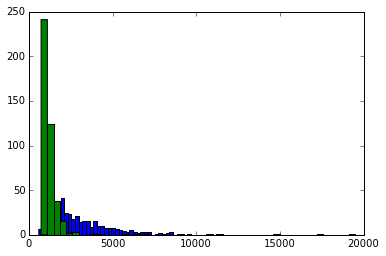

In [130]:
vmaxsx = []
vmaxsy = []

for trial in ftrials:
    vmaxsx.append(max(abs(trial.xv)))
    vmaxsy.append(max(abs(trial.yv)))
    
plt.hist(vmaxsx, bins = 50)
plt.hist(vmaxsy, bins = 50)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,  432.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.5 , -0.48, -0.46, -0.44, -0.42, -0.4 , -0.38, -0.36, -0.34,
        -0.32, -0.3 , -0.28, -0.26, -0.24, -0.22, -0.2 , -0.18, -0.16,
        -0.14, -0.12, -0.1 , -0.08, -0.06, -0.04, -0.02,  0.  ,  0.02,
         0.04,  0.06,  0.08,  0.1 ,  0.12,  0.14,  0.16,  0.18,  0.2 ,
         0.22,  0.24,  0.26,  0.28,  0.3 ,  0.32,  0.34,  0.36,  0.38,
         0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ]),
 <a list of 50 Patch objects>)

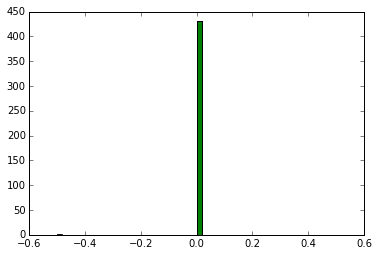

In [131]:
amaxsx = []
amaxsy = []

for trial in ftrials:
    amaxsx.append(min(abs(trial.xa)))
    amaxsy.append(min(abs(trial.ya)))

    
plt.hist(amaxsx, bins = 50)
plt.hist(amaxsy, bins = 50)

Given these examples, it seems microsaccades are large increases in velocity. Perhaps we can identify them by finding a large velocity over 5 or more frames.

The microsaccades usually look like steady progression in the same direction, so Perhaps a better way is to look for same large velocity over 5 or more frames, and a very low acceleration to identify a microsaccade.

In [132]:
wsize = 7

nmstrials = []
mstrials = []
exv = 0
exa = 0
exd = 0
for trial in ftrials:

    ##max of trial
    if(0):
        xv = max(abs(trial.xv))
        yv = max(abs(trial.yv))
        vmax = 0
        if(xv > vmax):
            vmax = xv
        if(yv > vmax): 
            vmax = yv

    ##check window for small acceleration and large velocity
    if(1):
        vmax = 0
        amin = 1e10
        dmax = 0
        for i in range(0, len(trial.x)-wsize):
            ##velocity
            xv = sum(abs(trial.xv[i:i+wsize]))/wsize
            yv = sum(abs(trial.yv[i:i+wsize]))/wsize
            euv = np.sqrt(xv**2 + yv**2)
            ##acceleration
            xa = sum(abs(trial.xa[i:i+wsize]))/wsize
            ya = sum(abs(trial.ya[i:i+wsize]))/wsize
            eua = np.sqrt(xa**2 + ya**2)
            ##displacement
            d = np.sqrt((trial.x[i] - trial.x[i+wsize])**2 + 
                        (trial.y[i] - trial.y[i+wsize])**2)/wsize
            if(euv > vmax):
                vmax = euv
                #print l'xv is ',xv
            if(eua < amin):
                amin = eua
                #print xa
            if(d > dmax):
                dmax = d
                #print 'yv is ',yv
            #if(ya < amin):
            #    amin = ya   
                #print ya
            #elif(i%100 == 0):
            #    print 'xv is ',xv
            #    print xa
                
    ##check what maxv ended up being and append if needed
    #print 'vmax is',vmax
    #print 'amin is',amin
    #print 'dmax is', dmax
    #if((vmax > 0.1) & (amin < 1e5)):
    #optimal values for amin is 3e-10 to max good trials ans remove microsaccades
    if(amin < 5e-10):
        #print amin
        exa += 1
        mstrials.append(trial)
    elif(vmax > 1e10):
        #print vmax
        exv +=1
        mstrials.append(trial)
    elif(dmax > 1):
        #print dmax
        exd +=1
        mstrials.append(trial)
    else:
        nmstrials.append(trial)
        
print 'bad trials: ',len(mstrials)
print 'good trials: ',len(nmstrials)
print 'excluded by amin: ',exa
print 'excluded by vmax: ',exv
print 'excluded by dmax: ',exd

bad trials:  381
good trials:  51
excluded by amin:  381
excluded by vmax:  0
excluded by dmax:  0


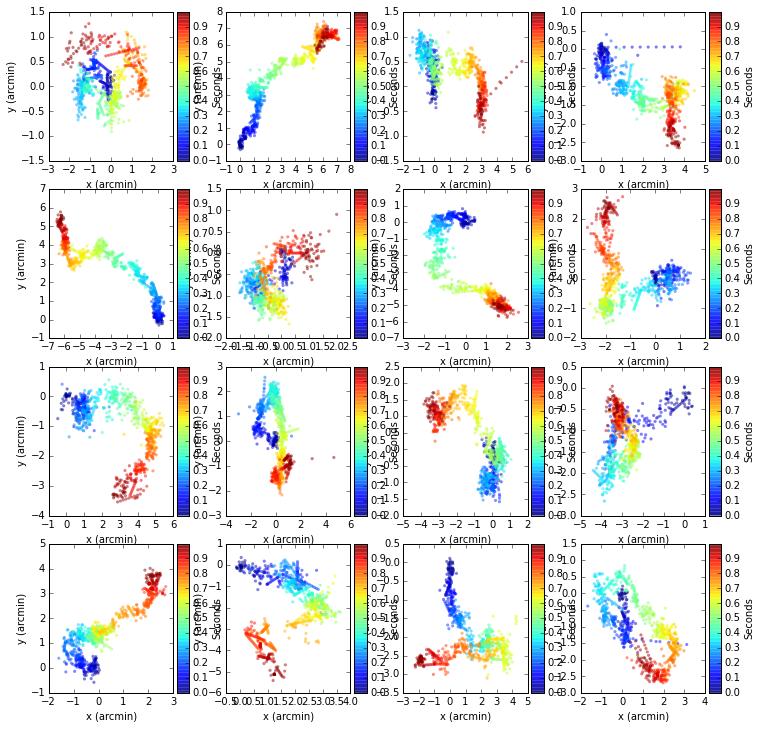

In [133]:
##calc number of rows needed with 2 cols
ncol = 4
nrow = int(math.ceil(16 / ncol))

#Show early -> late progression
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

for i, pl in enumerate(ax.flatten()):
    trial = mstrials[i+10]
    im = pl.scatter(trial.x, trial.y, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Seconds')

plt.show()

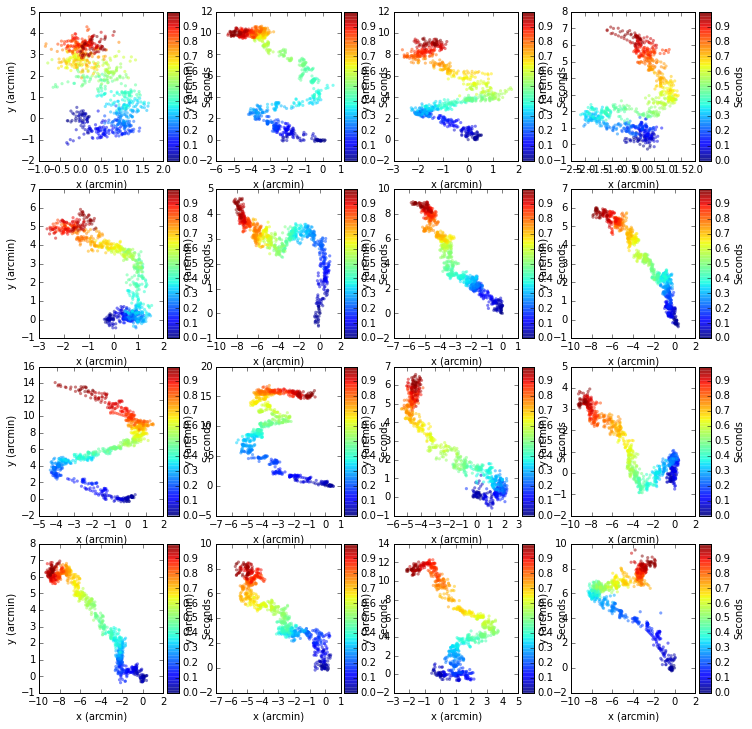

In [134]:
##calc number of rows needed with 2 cols
ncol = 4
nrow = int(math.ceil(16/ ncol))

#Show early -> late progression
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
plt.tight_layout()

for i, pl in enumerate(ax.flatten()):
    trial = nmstrials[i+24]
    im = pl.scatter(trial.x, trial.y, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label('Seconds')

plt.show()

This is really hard to detect well. Make trace images for each trial so we can manually check some of them

In [135]:
from pylab import savefig
if(0):
    for trial in ftrials:
        plt.scatter(trial.x, trial.y, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
        plt.xlabel('x (arcmin)')
        plt.ylabel('y (arcmin)')
        #pl.axis('equal') ##comment this in and out
        ##add colorbar
        #div = make_axes_locatable(pl)
        #cax = div.append_axes("right", size="10%", pad=0.05)
        #cbar = plt.colorbar(im, cax=cax)
        #cbar.set_label('Seconds')
        #print trial.fname
        plt.savefig(trial.fname + '.png')
        plt.clf()  # Clear the figure for the next loop

Now that we've identified bad trials, filter them out.

In [136]:
ftrials = copy.deepcopy(nmstrials)
for trial in ftrials:
    trial.filterinfo = trial.filterinfo + "2) Microsaccade-like trials discarded.\n"

##  Plot FFT & Power Spectrum 

Let's see what the power spectrum looks like for this data. Then try to combine samples and calculate.

### Absolute value

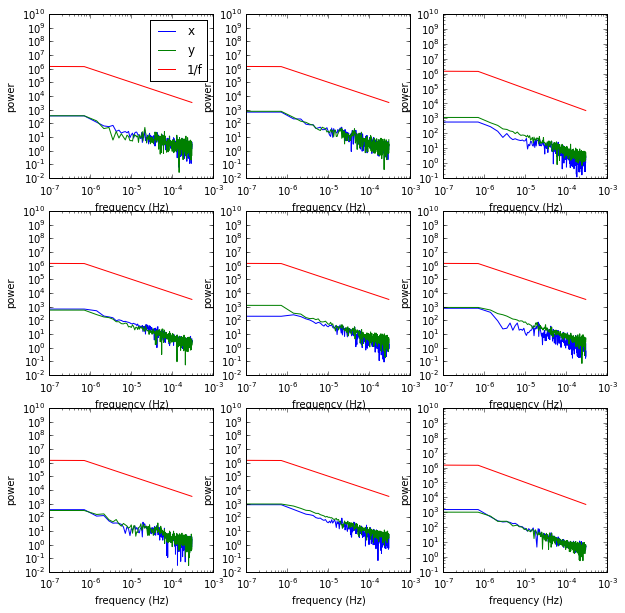

In [137]:
import numpy as np
from scipy.fftpack import fft


##calc number of rows needed with 2 cols
ncol = 3
nrow = int(math.ceil(9/ ncol))

fig, ax = plt.subplots(nrow, ncol, figsize=(10,10))
tstep = float(2*len(ftrials[0].x)) #this is the Nyquist frequency (2x sampling rate)

for i, pl in enumerate(ax.flatten()):
    trial = ftrials[i]
    
    #X direction
    xfq = np.fft.fftshift(np.fft.fftfreq(len(trial.x), tstep))
    xps = np.fft.fftshift(np.abs(np.fft.fft(trial.x)))
    #Y direction
    yfq = np.fft.fftshift(np.fft.fftfreq(len(trial.y), tstep))
    yps = np.fft.fftshift(np.abs(np.fft.fft(trial.y)))
    ##plot it
    pl.plot(xfq, xps, label = 'x')
    pl.plot(yfq, yps, label = 'y')
    ##plot 1/f
    pl.plot(xfq, 1/(xfq+1e-10), label = '1/f')

    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')
    ##labels
    pl.set_xlabel('frequency (Hz)')
    pl.set_ylabel('power')
    ##legend
    if(i==0):
        pl.legend(loc = 0)
plt.show()


## Reproduce Engbert & Kliegl, 2004

A first step is to reproduce what was done by the Engbert & Kliegl, 2004 paper. See notes here in Modeling section of: [Eye Movement Research Notes: Engbert & Kliegl, 2004](Eye Movement Research Notes.ipynb)  

A brief overview:  

*  Measure temporal evolution of mean square displacement $(\Delta x^2)$ from FBM equation for eye movement: $(\Delta x^2) \propto \Delta t^H$. Use experimental data to calculate $H$ as slope of log-log plot of equation for mean square displacement: $D^2 $ over time $t$ for each time step using equation: $$ D^2 (m) = \frac{1}{N-m}\sum_{i=1}^{N-m}\|{\vec{x}_{i+m} - \vec{x}_i}\|^2$$ where $N$ is number of samples in recorded time series, $m$ is time lag measured as number of data samples.  


*  Sew together time courses without microsaccades and test $H$ again. We have already eliminated microsaccades - or so we think. Some samples we have already looked at contain large jumps. May want to reevaluate these jumps in the future, make sure we are still looking at ONLY drift.

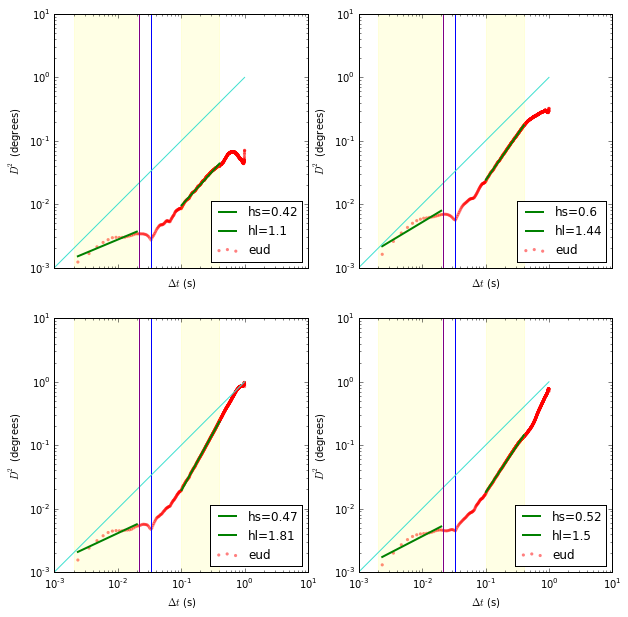

In [138]:
##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(ftrials[0:4]) / ncol))

##calc mean hl and means hs
hs = []
hl = []

##make figures
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = ftrials[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time')
    for m in range(1,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##convert to degrees to compare with paper
    eudist = eudist/60
    
    ##plot x, y, and eud
    #pl.scatter(trial.time, xdist, label= 'x', s=10, alpha=0.5, edgecolors='none', color='blue')
    #pl.scatter(trial.time, ydist, label= 'y', s=10, alpha=0.5, edgecolors='none', color='green')
    pl.scatter(trial.time, eudist, label= 'eud', s=10, alpha=0.5, edgecolors='none', color='red')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    pl.axvspan(0.002, 0.02, alpha=0.1, color='yellow')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(0.1, 0.4, alpha=0.1, color='yellow')

    ##also plot line for scaling exponent H = 1
    #pl.plot(trial.time, trial.time, color='purple')
    
    ##calculate slopes Hs and Hl (at limits from E&K) (Euclidian only)
    ##Hs time 2ms -> 20ms
    hsmask = (trial.time > 0.002) & (trial.time < 0.02)
    hstime = trial.time[hsmask]
    hseudist = eudist[hsmask]
    ##run least square regression of 1st degree on the log-scale values.
    #The equation for a line on a log–log scale would be:
    #log{10}Y = m*log{10}x + b
    #Y = x^m*10^b, 
    #where m is the slope and b is the intercept point on the log plot
    #hslmm, hslmb = np.polyfit(hstime, hseudist, deg=1)
    hslm, hslb = np.polyfit(np.log10(hstime), np.log10(hseudist), deg=1)
    hs.append(hslm)
    #hsmv = np.add(np.multiply(hslm, hstime), hslb)
    hsmv = hstime**hslm*10**hslb
    #hslmp = np.poly1d(hslm) #convenience class for polynomials
    pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslm,2)))     

    #hsmv = np.add(np.multiply(hslmm, hstime), hslmb)
    #pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslmm,2)))     
    ##Hl time 100ms -> 400ms
    hlmask = (trial.time > 0.1) & (trial.time < 0.4)
    hltime = trial.time[hlmask]
    hleudist = eudist[hlmask]
    ##run least square regression of 1st degree
    hllmm, hllmb = np.polyfit(np.log10(hltime), np.log10(hleudist), deg=1)
    hl.append(hllmm)
    #hlmv = np.add(np.multiply(hllmm, hltime), hllmb)
    hlmv = hltime**hllmm*10**hllmb
    pl.plot(hltime, hlmv, color = 'green', linewidth = 2, label = 'hl=%s'%(round(hllmm,2)))
     
    ##plot knee
    pl.axvline(.033, color = 'blue')
    
    ##also plot line for scaling exponent H = 1
    pl.plot(trial.time, trial.time, color='turquoise')
    
    ##plot time to compare one strip to last (41 strips)
    #1/(1920/41) =  0.02135
    pl.axvline(.02135, color = 'purple')
    
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$ (degrees)')
    
    #legend
    pl.legend(loc = 0)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)


In [139]:
print 'hs mean:',round(np.mean(hs),3)
print 'hs sd:',round(np.std(hs),3)
print 'hl mean:',round(np.mean(hl),3)
print 'hl sd:',round(np.std(hl),3)

hs mean: 0.501
hs sd: 0.068
hl mean: 1.461
hl sd: 0.252


### Discussion
Once figuring out the correct equation for plotting, these slopes hs and hs appear to fit well to the data for euclidian distance.

For our data, hs is distinctly lower than hl, that is to say that the slope of our data for the short and long term are NOT the same, in fact the slope in the long term is higher. This means that rate of displacement (scaling factor of H) is higher over long lag times. This larger scaling factor seems to be consistent over the entire timescale after 0.033 seconds, or in the case of our data, about 63 frames (=1920 x 0.033). For a full image, there are 40 strips, so we need to be sure we understand how each strip is compared with the previous in order to determine how updates are made. If the update is compared with the same strip in the previous frame rather than the previous strip, this artifact may make sense.  

<img style="float: left;" src="img/ektable.png">

One intersting finding however, is that the values we found for hl, which should not be affected by this 40Hz difference, are MUCH higher than what E&K found, even when converting to degrees, as in their paper. We find values for $H_L$ to be 1.7-1.8, while even in the saccade removed trials (which should correspond to our data, we simply through out data with saccades in them), values were 1.22. Short time scales in their paper were a bit larger, but still smaller than our values.  

So, in reproducing E&K for the LONG lag time, we find H, the scaling exponent for displacement to be much greater than 1, around 1.8, and our equation for the diffusion model is $(\Delta x^2) \propto \Delta t^H$, with $H \approx 1.8$. This corresponds to persistant motion.  

One possible explanation of this difference is in the experimental setup, in E&K it isn't specified what subjects are instructed to fixate at, but in the case of our data, they are fixating straight ahead, and instructed to attend to something in the periphery. Perhaps the focus of attention towards this peripheral stimulus causes drift to shirt in this direction, and to be more persistant than was found in E&K.

## Implemeting Kalmnn Filter (Adapted from Alex's Code)

The Kalmann filter in Python is pykalman KalmanFilter. We will be modeling position and velocity for x and for y.  

It takes some parameters: 

1. initial_state_mean: (4x1 vector) zero for all parameters. This means we start at value zero for position and velocity, for both x and y.  

2. initial_state_covariance: (4x4 matrix) observation noise for x, and y postiion (assumed same), zero for everything else. This means we include stoichasity at the expected value for change in velocity at each time step.  

3. transition_matrices: (4x4 matrix) 1 along diagnoals, dt at velocity values for transitions, zero everywhere else. This means at each timestep, we keep our position, and add dt (velocity).  

4. transition_covariance: (4x4 matrix) hidden state transition noise at transition values for x and y velocity (assumed same), zero everywhere else. This means we include stoichaisity at the noise rate when we take a timestep.  

5. observation_matrices: (4x2 matrix) zero for velocity values (we don't observe them), 1 for position values. This means we observe x position and y position, the 1st and 3rd values in the vector (intial state mean).  

6. observation_covriance: (2x2 matrix) observation noise on x and y position, 0 everywhere else. This means we have some error in observing position for x and for y.  

The parameters we need to choose then are (for x and y) :

1. initial position covariance **(ivx, ivy) **   
    Estimate this by variance of the first two velocities  
    
2. velocity transition matrix **(dt)  **  
    This is the time from one frame to another in order to correctly calculate velocity. 1/numberofframes
    
3. velocity transition covariance **(tvx, tvy) **   
    Estimating this by the variance of velocity gives much too large numbers, because in reality our hidden state transition covariance is much lower than what we measure. So use a search to find the best one.
    
3. observation noise covariance **(ov)  **  
    This is known from Arathorn 2009 -> SD = 0.25
    
First define our function for fft filtering

In [179]:
def filterfft(trialsf, ivx, ivy, mtvx, mtvy, ov):
    
    #make a new list so we dont edit the old one
    ntrialsf = copy.deepcopy(trialsf)
    
    for trial in ntrialsf:
        
        ##dt is the time transition matrix - how much we change in 1 frame in time scale
        ##this should be the same for all trials, but for correctness we should calculate it on a trial basis.
        dt = 1./len(trial.time) #units are seconds

        ##want tvx to be time invariant (larger for larger time steps) so our values of tvx is in units of m/s (an acceleration (m/s^2) times dt (s))
        #change here from mtv (samling rate invariant tv) to tv specific for this experiment that is scaled for the time course.
        ##in other words this is changing tv to a velocity that can be added to the velocity value.
        ##here is the distinction between noise in velocity and acceleration.
        tvx = mtvx * (dt)
        tvy = mtvy * (dt)

        # the adjustment value A keeps our velocities from growing.
        #A = sqrt(1-(sigmatv/sigmanot)^2))
        adj = np.sqrt(1.-(tvx/ivx)**2)
        #adj = 1

            ##matrices:
        initial_state_mean = np.array([0, 0, 0, 0])

        initial_state_cov = np.array([[0, 0, 0, 0], 
                                      [0, ivx, 0, 0], 
                                      [0, 0, 0, 0],
                                      [0, 0, 0, ivy]])

        transition_mat = np.array([[1, dt, 0, 0],
                                   [0, adj, 0, 0], 
                                   [0, 0, 1, dt],
                                   [0, 0, 0, adj]])

        transition_cov = np.array([[0, 0, 0, 0], 
                                   [0, tvx, 0, 0], 
                                   [0, 0, 0, 0],
                                   [0, 0, 0, tvy]])

        observation_mat = np.array([[1, 0, 0, 0],
                                    [0, 0, 1, 0]])

        observation_cov = np.array([[ov, 0], 
                                    [0, ov]])

        ##initialize filter 
        kf = KalmanFilter(initial_state_mean = initial_state_mean,
                          initial_state_covariance = initial_state_cov,
                          transition_matrices = transition_mat,
                          transition_covariance = transition_cov,
                          observation_matrices = observation_mat,
                          observation_covariance = observation_cov
                         )

        ##make matrix of measurements
        measurements = np.vstack((trial.x,trial.y)).T

        #smooth
        (smoothed_state_means, smoothed_state_cov) = kf.smooth(measurements)

        trial.x = smoothed_state_means[:, 0]
        trial.y = smoothed_state_means[:, 2]
        trial.xv = smoothed_state_means[:, 1]
        trial.yv = smoothed_state_means[:, 3]

        trial.xcov = smoothed_state_cov[:, 0, 0]
        trial.ycov = smoothed_state_cov[:, 2, 2]
        trial.xvcov = smoothed_state_cov[:, 1, 1]
        trial.yvcov = smoothed_state_cov[:, 3, 3]

        
        ##interpolate veclotiy from new smoothed position values
        #trial.xv = np.concatenate([[trial.x[1] - trial.x[0]],
        #                             trial.x[1:] - trial.x[:-1]]) * len(trial.time) #in seconds
        #trial.yv = np.concatenate([[trial.y[1] - trial.y[0]],
        #                             trial.y[1:] - trial.y[:-1]]) * len(trial.time) #in seconds


        ##interpolate acceleration from new smoothed values
        trial.xa = np.concatenate([[trial.xv[1] - trial.xv[0]],
                                     trial.xv[1:] - trial.xv[:-1]]) * len(trial.time) #in seconds
        trial.ya = np.concatenate([[trial.yv[1] - trial.yv[0]],
                                     trial.yv[1:] - trial.yv[:-1]]) * len(trial.time) #in seconds


        trial.filterinfo = trial.filterinfo + '3) Kahlman Filter applied with paramters: tvx=%s, tvy=%s, ov=%s, ivx=%s, sigmapy=%s, dt=%s \n' % (tvx, tvy, ov, ivx, ivy, dt)
        trial.kfivx = ivx
        trial.kfivy = ivy
        trial.kftvx = tvx
        trial.kftvy = tvy
        trial.kfov = ov
        trial.kfdt = dt
        trial.kfadj = adj
        
    return ntrialsf

Now aggregate the values from all our trials and use the average values of these statistics to calculate our parameters for smoothing

In [202]:
#run KF with chosen parameter for dvcor and plot results

##IV is the covariance of the initial velocity
##Because the initial velocity is a gaussian about zero, 
##we can estimate it by the average value of velocity.
#aggivx = mean([mean(abs(getattr(tmp_obj, "xv"))[0]) for tmp_obj in ftrials])
#aggivy = mean([mean(abs(getattr(tmp_obj, "yv"))[0]) for tmp_obj in ftrials])
##since we have mutlple trials, calculate this directly.
#aggivx = np.var([getattr(tmp_obj, "xv")[0] for tmp_obj in ftrials]) 
#aggivy = np.var([getattr(tmp_obj, "yv")[0] for tmp_obj in ftrials]) 
aggivx = 1e2
aggivy = 1e2
print 'ivx is', aggivx
print 'ivy is', aggivy

dt = 1./840

##tvx and tvy is the error in velocity transition (acceleration) - this is multiplied by dt.
aggtvx = 1e2 ##how to calculate this?
aggtvy = 1e2 ##how to calculate this?
#aggtvx = aggivx*dt
#aggtvy = aggivy*dt
print 'tvx is', aggtvx
print 'tvy is', aggtvy

##OV is the observation noise. 
##This is equivalent to the noise that we expect in our measurement.
##We know that the AOSLO has an SD of error POSITION measurement of 0.1 arcmin (Arathorn, 2007)
##We assume this is the same in the x an y directions.
##variance = $SD^2$
ov = (0.1)**2 
#ov = 0.2**2 
print 'ov is',ov

kftrials = filterfft(ftrials, aggivx, aggivy, aggtvx, aggtvy, ov)

ivx is 100.0
ivy is 100.0
tvx is 100.0
tvy is 100.0
ov is 0.01


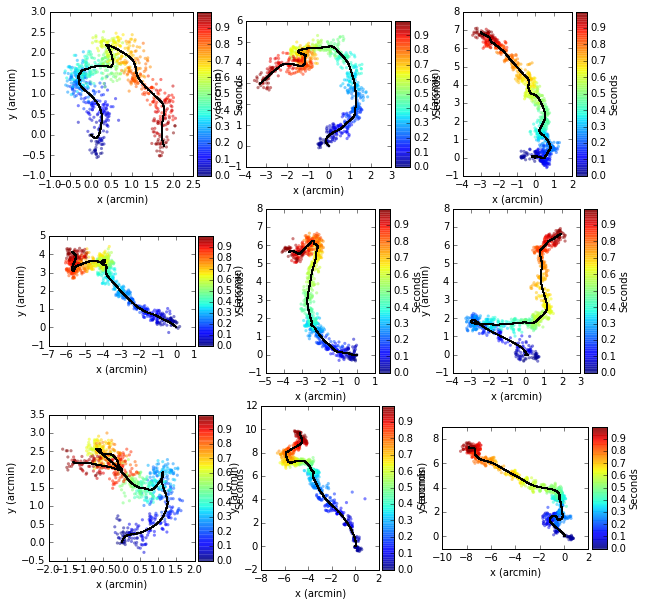

In [203]:
##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(9 / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = False )

for i, pl in enumerate(ax.flatten()):
    trial = kftrials[i]
    ##plot original data
    imraw = pl.scatter(trial.xraw, trial.yraw, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    pl.scatter(trial.x, trial.y, s=1, c='black')

#plt.show()

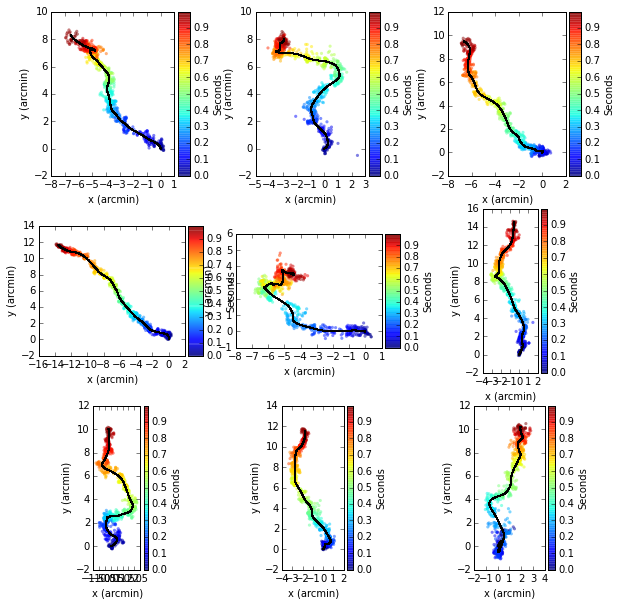

In [204]:
##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(9 / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = False )

for i, pl in enumerate(ax.flatten()):
    trial = kftrials[i+9]
    ##plot original data
    imraw = pl.scatter(trial.xraw, trial.yraw, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    pl.scatter(trial.x, trial.y, s=1, c='black')

#plt.show()

We have smoothed to some degree here. Because we choose slightly different parameters here than Alex chose, we have a very slightly different smoothing, but still similar.

we would also like to know if we are oversmoothing here. That is, how big are the error bars on our observation noise?

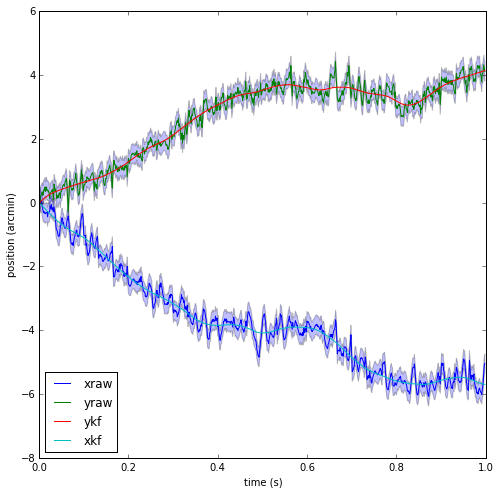

In [205]:
trial = kftrials[3]

#for i, pl in enumerate(ax.flatten()):
#    trial = trialskf[i]
    ##plot original data
plt.figure(figsize =(8,8))
plt.plot(trial.time, trial.xraw, label = 'xraw')
plt.plot(trial.time, trial.yraw, label = 'yraw')
    
#plot error JUST from observation noise
#xerror = np.random.normal(0, np.sqrt(trial.kfov), size=trial.x.shape)
#yerror = np.random.normal(0, np.sqrt(trial.kfov), size=trial.y.shape)
xerror = np.sqrt(trial.kfov)*3
yerror = np.sqrt(trial.kfov)*3
plt.fill_between(trial.time, trial.xraw-xerror, trial.xraw+xerror, alpha = 0.25)
plt.fill_between(trial.time, trial.yraw-yerror, trial.yraw+yerror, alpha = 0.25)

plt.plot(trial.time, trial.y, label = 'ykf')
plt.plot(trial.time, trial.x, label = 'xkf')


plt.xlabel('time (s)')
plt.ylabel('position (arcmin)')
plt.legend(loc = 3)


(-7.0, 1.0, -1.0, 5.0)

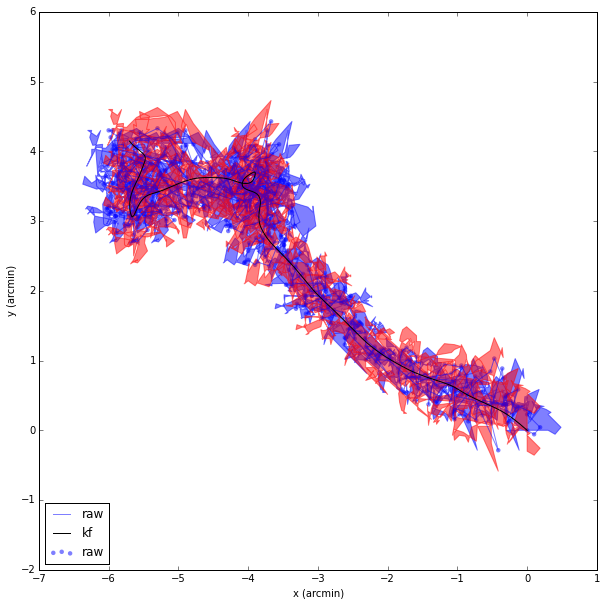

In [206]:
plt.figure(figsize =(10,10))

#plot raw data
plt.scatter(trial.xraw, trial.yraw, label = 'raw', alpha=0.5, edgecolors='none')
plt.plot(trial.xraw, trial.yraw, label = 'raw', alpha=0.5)

#plot smooth data
plt.plot(trial.x, trial.y, label = 'kf', color='black') 

#plot error JUST from observation noise
error = np.sqrt(trial.kfov)*3
#plt.fill_between(trial.time, trial.xraw-xerror, trial.xraw+xerror, alpha = 0.5)
plt.fill_betweenx(trial.yraw, trial.xraw-error, trial.xraw+error, alpha = 0.5, color='blue')
plt.fill_between(trial.xraw, trial.yraw-error, trial.yraw+error, alpha = 0.5, color='red')

plt.xlabel('x (arcmin)')
plt.ylabel('y (arcmin)')
plt.legend(loc = 3)
plt.axis('equal') ##comment this in and out

Also what is our covariance on our values for position?

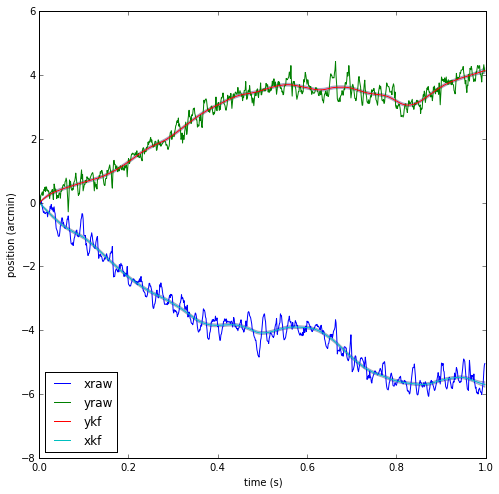

In [207]:
trial = kftrials[3]

#for i, pl in enumerate(ax.flatten()):
#    trial = trialskf[i]
    ##plot original data
plt.figure(figsize =(8,8))
plt.plot(trial.time, trial.xraw, label = 'xraw')
plt.plot(trial.time, trial.yraw, label = 'yraw')
    
#plot 3 standard deviations as given by 
#xerror = np.random.normal(0, np.sqrt(trial.kfov), size=trial.x.shape)
#yerror = np.random.normal(0, np.sqrt(trial.kfov), size=trial.y.shape)
xerr = np.sqrt(trial.xcov)*3
yerr = np.sqrt(trial.ycov)*3

plt.plot(trial.time, trial.y, label = 'ykf')
plt.plot(trial.time, trial.x, label = 'xkf')

plt.fill_between(trial.time, 
                trial.x - xerr, 
                 trial.x + xerr, alpha = 0.25)
plt.fill_between(trial.time, 
                 trial.y - yerr,
                 trial.y + yerr, alpha = 0.25)


plt.xlabel('time (s)')
plt.ylabel('position (arcmin)')
plt.legend(loc = 3)


The covariance precicted by the KF is very small compared to the signal

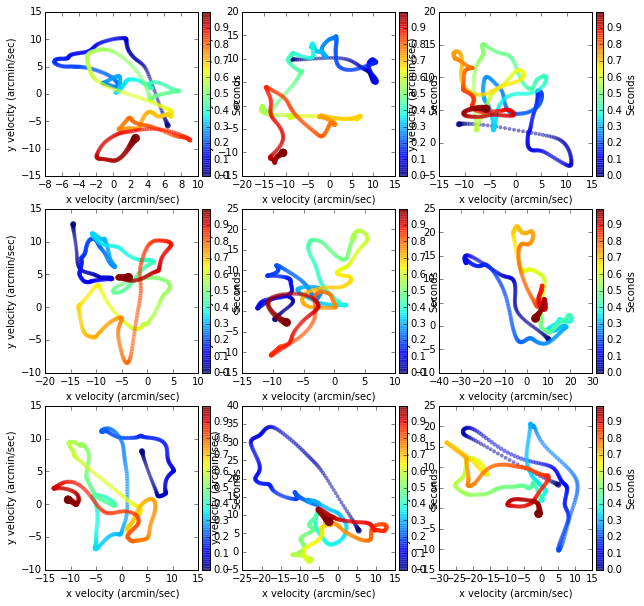

In [213]:
###### plot our new results for velocity

##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(9 / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = kftrials[i]
    ##plot original data
    #imraw = pl.scatter((trial.x[1:] - trial.x[:-1])*len(trial.time), (trial.y[1:] - trial.y[:-1])*len(trial.time), s=10, c=trial.time[:-1], cmap=cm.jet, alpha=0.5, edgecolors='none')
    xs = np.pi*(np.sqrt(trial.xvcov)*3)**2
    imraw = pl.scatter(trial.xv, trial.yv, s=xs, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x velocity (arcmin/sec)')
    pl.set_ylabel('y velocity (arcmin/sec)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')

plt.show()

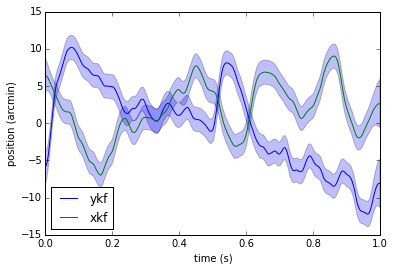

In [216]:
trial = kftrials[0]

#plot 3 standard deviations as given by 
#xerror = np.random.normal(0, np.sqrt(trial.kfov), size=trial.x.shape)
#yerror = np.random.normal(0, np.sqrt(trial.kfov), size=trial.y.shape)
xerr = np.sqrt(trial.xvcov)*2
yerr = np.sqrt(trial.yvcov)*2

plt.plot(trial.time, trial.yv, label = 'ykf')
plt.plot(trial.time, trial.xv, label = 'xkf')

plt.fill_between(trial.time, 
                trial.xv - xerr, 
                 trial.xv + xerr, alpha = 0.25)
plt.fill_between(trial.time, 
                 trial.yv - yerr,
                 trial.yv + yerr, alpha = 0.25)


plt.xlabel('time (s)')
plt.ylabel('position (arcmin)')
plt.legend(loc = 3)


This looks a whole lot more realistic for a velocity progression than our pre-filtering plot of velocity.  Also, the smooth velocities from the KF and the velocitied inferred from the smoothed positions are equivalent. This means the velocity is being calculated correctly. Interestinly, these are quite different velocities than when we used a different value for dx. This makes some sense because we are multiplying the velocity by a different number every time.

Let's now look at acceleration.

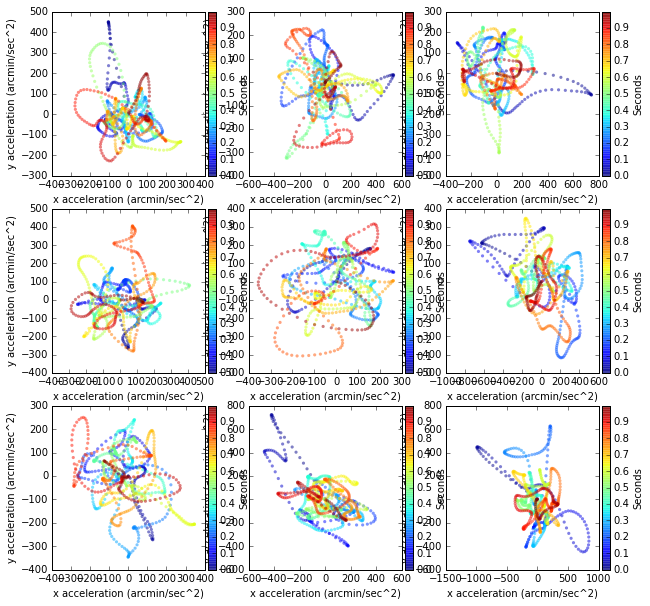

In [27]:
###### plot our new results for acceleration

##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(9 / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = kftrials[i]
    ##plot original data
    #imraw = pl.scatter((trial.xv[1:] - trial.xv[:-1])*len(trial.time), (trial.yv[1:] - trial.yv[:-1])*len(trial.time), s=10, c=trial.time[:-1], cmap=cm.jet, alpha=0.5, edgecolors='none')
    #imraw = pl.scatter((trial.xv[1:] - trial.xv[:-1]), (trial.yv[1:] - trial.yv[:-1]), s=10, c=trial.time[:-1], cmap=cm.jet, alpha=0.5, edgecolors='none')
    imraw = pl.scatter(trial.xa, trial.ya, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x acceleration (arcmin/sec^2)')
    pl.set_ylabel('y acceleration (arcmin/sec^2)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')
    #pl.set_xscale('log')
    #pl.set_yscale('log')

plt.show()

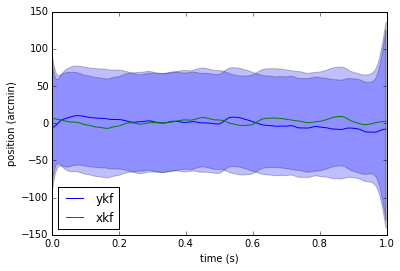

In [217]:
trial = kftrials[0]

#plot 3 standard deviations as given by 
#xerror = np.random.normal(0, np.sqrt(trial.kfov), size=trial.x.shape)
#yerror = np.random.normal(0, np.sqrt(trial.kfov), size=trial.y.shape)
xerr = np.sqrt((2*trial.xvcov)/trial.kfdt)*2
yerr = np.sqrt((2*trial.yvcov)/trial.kfdt)*2

plt.plot(trial.time, trial.yv, label = 'ykf')
plt.plot(trial.time, trial.xv, label = 'xkf')

plt.fill_between(trial.time, 
                trial.xv - xerr, 
                 trial.xv + xerr, alpha = 0.25)
plt.fill_between(trial.time, 
                 trial.yv - yerr,
                 trial.yv + yerr, alpha = 0.25)


plt.xlabel('time (s)')
plt.ylabel('position (arcmin)')
plt.legend(loc = 3)


This is SMOOTH for some reason. Why? We only model position and velocity, not position, so this is strange that the acceleration value changes smoothly through the time course, as I would have expected it to progress.

This implies that our data contains more structure than our model is predicting, as we model adding a random acceleration at each timepoint. 

Let's now validate our model parameters.

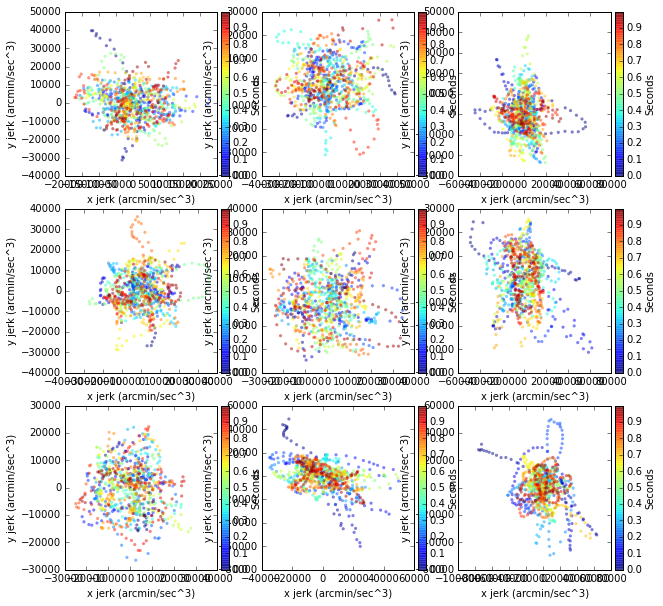

In [28]:
###### plot our new results for jerk

##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(9/ ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = kftrials[i]
    
    jex = np.concatenate([[np.subtract(trial.xa[1], trial.xa[0])],
                            np.subtract(trial.xa[1:], trial.xa[:-1])]
                          ) * len(trial.time) ##in seconds
    jey = np.concatenate([[np.subtract(trial.ya[1], trial.ya[0])],
                           np.subtract(trial.ya[1:], trial.ya[:-1])]
                          ) * len(trial.time) ##in seconds
    
    ##plot original data
    imraw = pl.scatter(jex, jey, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x jerk (arcmin/sec^3)')
    pl.set_ylabel('y jerk (arcmin/sec^3)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')

plt.show()

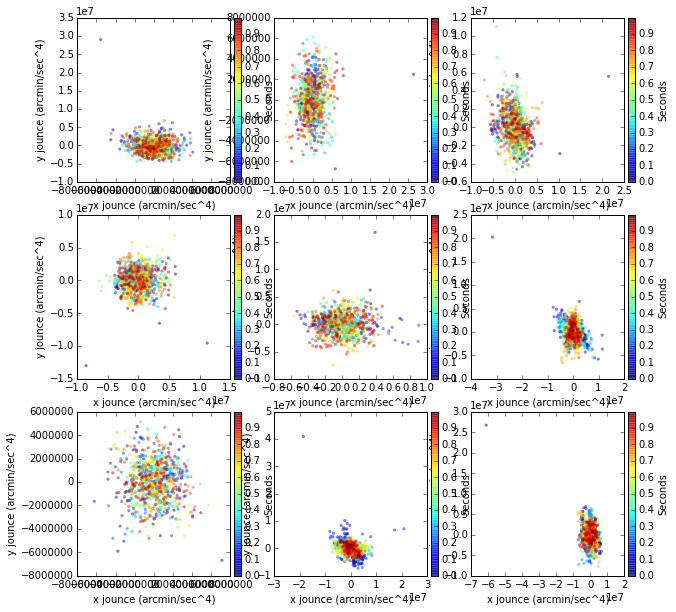

In [29]:
###### plot our new results for jounce/snap

##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(9 / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = kftrials[i]
    ##plot original data
    jex = np.concatenate([[np.subtract(trial.xa[1], trial.xa[0])],
                            np.subtract(trial.xa[1:], trial.xa[:-1])]
                          ) * len(trial.time) ##in seconds
    jey = np.concatenate([[np.subtract(trial.ya[1], trial.ya[0])],
                           np.subtract(trial.ya[1:], trial.ya[:-1])]
                          ) * len(trial.time) ##in seconds
    jox = np.concatenate([[np.subtract(jex[1], jex[0])],
                            np.subtract(jex[1:], jex[:-1])]
                          ) * len(trial.time) ##in seconds
    joy = np.concatenate([[np.subtract(jey[1], jey[0])],
                            np.subtract(jey[1:], jey[:-1])]
                          ) * len(trial.time) ##in seconds

    
    ##plot original data
    imraw = pl.scatter(jox, joy, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x jounce (arcmin/sec^4)')
    pl.set_ylabel('y jounce (arcmin/sec^4)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')

plt.show()

This is no longer smooth but we still see some structure in clustering of values of recordings close in the time trajectory.

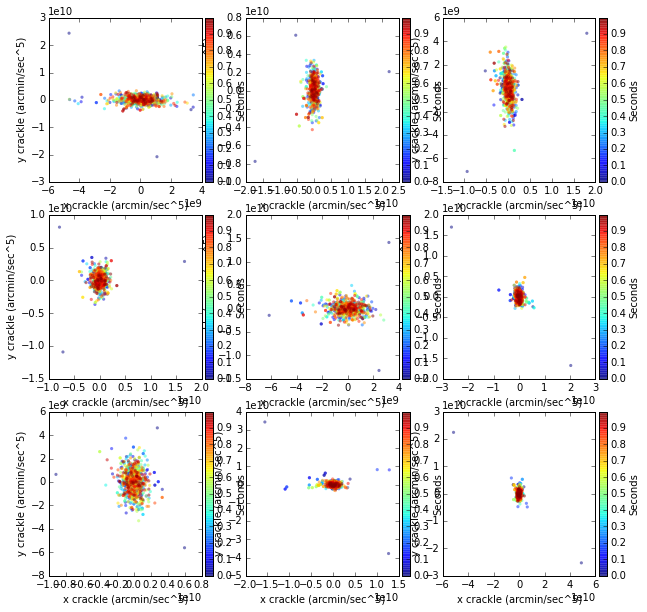

In [30]:
###### plot our new results for crackle

##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(9 / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = kftrials[i]
    ##plot original data
    jex = np.concatenate([[np.subtract(trial.xa[1], trial.xa[0])],
                            np.subtract(trial.xa[1:], trial.xa[:-1])]
                          ) * len(trial.time) ##in seconds
    jey = np.concatenate([[np.subtract(trial.ya[1], trial.ya[0])],
                           np.subtract(trial.ya[1:], trial.ya[:-1])]
                          ) * len(trial.time) ##in seconds
    jox = np.concatenate([[np.subtract(jex[1], jex[0])],
                            np.subtract(jex[1:], jex[:-1])]
                          ) * len(trial.time) ##in seconds
    joy = np.concatenate([[np.subtract(jey[1], jey[0])],
                            np.subtract(jey[1:], jey[:-1])]
                          ) * len(trial.time) ##in seconds
    crx = np.concatenate([[np.subtract(jox[1], jox[0])],
                            np.subtract(jox[1:], jox[:-1])]
                          ) * len(trial.time) ##in seconds
    cry = np.concatenate([[np.subtract(joy[1], joy[0])],
                            np.subtract(joy[1:], joy[:-1])]
                          ) * len(trial.time) ##in seconds

    
    ##plot original data
    imraw = pl.scatter(crx, cry, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x crackle (arcmin/sec^5)')
    pl.set_ylabel('y crackle (arcmin/sec^5)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')

plt.show()

OK Truly here we are lost all information. This is truly noise.

#### Histograms of Velocity

Next we look at our choice of iv. This is the covariance in our velocity at timestep 0.

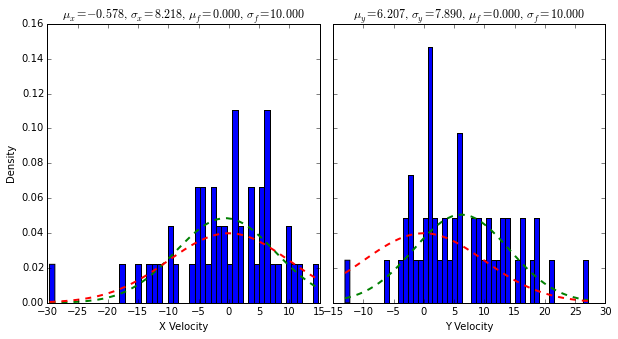

In [38]:
import matplotlib.mlab as mlab
from scipy.stats import norm


fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,5))

##X
##hist of data
fivx = [getattr(tmp_obj, "xv")[0] for tmp_obj in kftrials]
xn, xbins, xpatches = ax1.hist(fivx, normed=1, bins = 50)

# best fit of data
(xmu,xsigma) = norm.fit(fivx)
xfit = mlab.normpdf(xbins, xmu, xsigma)
ax1.plot(xbins, xfit, 'g--', linewidth=2)

# chosen parameters
xfmu = 0 #np.mean(trial.xv)
xfsig = np.sqrt(kftrials[0].kfivx)
sigmapxfit = mlab.normpdf(xbins, xfmu, xfsig)
ax1.plot(xbins, sigmapxfit, 'r--', linewidth=2)

# ##all velocities
# fivx = [getattr(tmp_obj, "xv")[0] for tmp_obj in kftrials]
# xn, xbins, xpatches = ax1.hist(fivx, normed=1, bins = 50)
# # best fit of data
# (xmu,xsigma) = norm.fit(fivx)
# xfit = mlab.normpdf(xbins, xmu, xsigma)
# ax1.plot(xbins, xfit, 'g--', linewidth=2)

##labels
ax1.set_title(r'$\mu_{x}=%.3f,\ \sigma_{x}=%.3f,\ \mu_{f}=%.3f,\ \sigma_{f}=%.3f$' %(xmu, xsigma, round(xfmu,3), round(xfsig,3)))
ax1.set_xlabel('X Velocity')
ax1.set_ylabel('Density')

##Y 
##hist of data
fivy = [getattr(tmp_obj, "yv")[0] for tmp_obj in kftrials]
yn, ybins, ypatches = ax2.hist(fivy, normed=1, bins = 50)

# best fit of data
(ymu,ysigma) = norm.fit(fivy)
yfit = mlab.normpdf(ybins, ymu, ysigma)
ax2.plot(ybins, yfit, 'g--', linewidth=2)

# best fit of params
yfmu = 0 #np.mean(trial.yv)
yfsig = np.sqrt(kftrials[0].kfivy) ##kfivy is the varaiance
sigmapyfit = mlab.normpdf(ybins, yfmu, yfsig)
ax2.plot(ybins, sigmapyfit, 'r--', linewidth=2)

##labels
ax2.set_title(r'$\mu_{y}=%.3f,\ \sigma_{y}=%.3f,\ \mu_{f}=%.3f,\ \sigma_{f}=%.3f$' %(ymu, ysigma, round(yfmu,3), round(yfsig,3)))
ax2.set_xlabel('Y Velocity')

##tidy up
fig.subplots_adjust(hspace=1, wspace=.05)


#### Histograms of Acceleration

Now look at our choice of tvx. This is the values for instintaneous acceleration

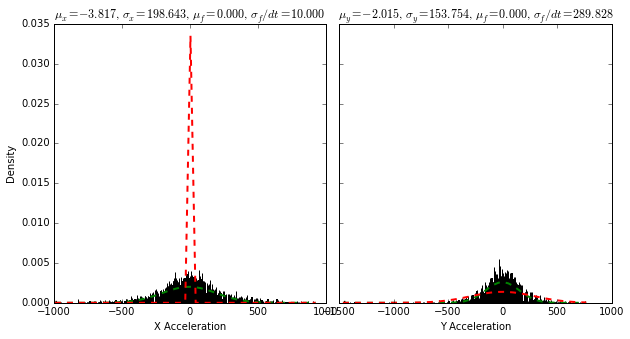

In [39]:
import matplotlib.mlab as mlab
from scipy.stats import norm

fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (10,5))

##X
##hist of data
ftvx = [getattr(tmp_obj, "xa") for tmp_obj in kftrials]
xn, xbins, xpatches = ax1.hist(ftvx, normed=1, bins = 50)

# best fit of data
(xmu,xsigma) = norm.fit(ftvx)
xfit = mlab.normpdf(xbins, xmu, xsigma)
ax1.plot(xbins, xfit, 'g--', linewidth=2)

# best fit of params
xfmu = 0 #np.mean(trial.xv)
xfsig = np.sqrt(kftrials[0].kftvx/dt) #*kftrials[0].kfdt
sigmapxfit = mlab.normpdf(xbins, xfmu, xfsig)
ax1.plot(xbins, sigmapxfit, 'r--', linewidth=2)

##labels
ax1.set_title(r'$\mu_{x}=%.3f,\ \sigma_{x}=%.3f,\ \mu_{f}=%.3f,\ \sigma_{f}/dt=%.3f$' %(xmu, xsigma, round(xfmu,3), round(xfsig,3)))
ax1.set_xlabel('X Acceleration')
ax1.set_ylabel('Density')

##Y 
##hist of data
ftvy = [getattr(tmp_obj, "ya") for tmp_obj in kftrials]
yn, ybins, ypatches = ax2.hist(ftvy, normed=1, bins = 50)

# best fit of data
(ymu,ysigma) = norm.fit(ftvy)
yfit = mlab.normpdf(ybins, ymu, ysigma)
ax2.plot(ybins, yfit, 'g--', linewidth=2)

# best fit of params
yfmu = 0 #np.mean(trial.yv)
yfsig = np.sqrt(kftrials[0].kftvy)/dt #*kftrials[0].kfdt
sigmapyfit = mlab.normpdf(ybins, yfmu, yfsig)
ax2.plot(ybins, sigmapyfit, 'r--', linewidth=2)

##labels
ax2.set_title(r'$\mu_{y}=%.3f,\ \sigma_{y}=%.3f,\ \mu_{f}=%.3f,\ \sigma_{f}/dt=%.3f$' %(ymu, ysigma, round(yfmu,3), round(yfsig,3)))
ax2.set_xlabel('Y Acceleration')

##tidy up
fig.subplots_adjust(hspace=1, wspace=.05)

This is not a great fit at all. I think this is because we need to model acceleration explicitly, as it is smooth. 

#### Histograms of Observation noise

Now look at our choice of Sigmao

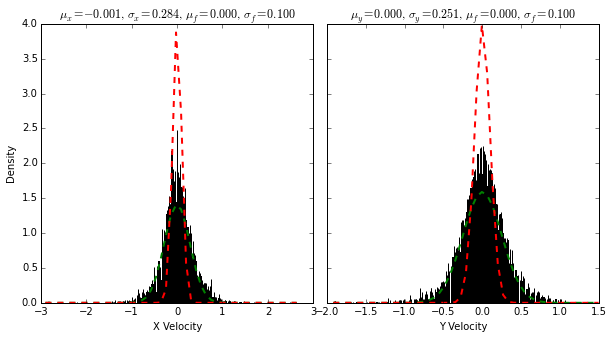

In [40]:
import matplotlib.mlab as mlab
from scipy.stats import norm

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (10,5))

##X
##hist of data
xo = [np.subtract(getattr(tmp_obj, "x"), getattr(tmp_obj, "xraw")) for tmp_obj in kftrials]
#print xo
xn, xbins, xpatches = ax1.hist(xo, normed=1, bins = 50)

# best fit of data
(xmu,xsigma) = norm.fit(xo)
xfit = mlab.normpdf(xbins, xmu, xsigma)
ax1.plot(xbins, xfit, 'g--', linewidth=2)

# best fit of params
xfmu = 0 #np.mean(trial.xv)
xfsig = np.sqrt(kftrials[0].kfov)
sigmapxfit = mlab.normpdf(xbins, xfmu, xfsig)
ax1.plot(xbins, sigmapxfit, 'r--', linewidth=2)

##labels
ax1.set_title(r'$\mu_{x}=%.3f,\ \sigma_{x}=%.3f,\ \mu_{f}=%.3f,\ \sigma_{f}=%.3f$' %(xmu, xsigma, round(xfmu,3), round(xfsig,3)))
ax1.set_xlabel('X Velocity')
ax1.set_ylabel('Density')

##Y 
##hist of data
yo = [np.subtract(getattr(tmp_obj, "y"), getattr(tmp_obj, "yraw")) for tmp_obj in kftrials]
yn, ybins, ypatches = ax2.hist(yo, normed=1, bins = 50)

# best fit of data
(ymu,ysigma) = norm.fit(yo)
yfit = mlab.normpdf(ybins, ymu, ysigma)
ax2.plot(ybins, yfit, 'g--', linewidth=2)

# best fit of params
yfmu = 0 #np.mean(trial.yv)
yfsig = np.sqrt(kftrials[0].kfov)
sigmapyfit = mlab.normpdf(ybins, yfmu, yfsig)
ax2.plot(ybins, sigmapyfit, 'r--', linewidth=2)

##labels
ax2.set_title(r'$\mu_{y}=%.3f,\ \sigma_{y}=%.3f,\ \mu_{f}=%.3f,\ \sigma_{f}=%.3f$' %(ymu, ysigma, round(yfmu,3), round(yfsig,3)))
ax2.set_xlabel('Y Velocity')

##tidy up
fig.subplots_adjust(hspace=1, wspace=.05)

This value is pretty good. Perhaps a little low, but close.

## Simulated Data
Now generate some data from our parameters

In [41]:
from numpy import arange

def gentrial(ivx, ivy, dt, tvx, tvy, ov, adj):
    
    timesteps = int(1/dt) + 1
    #print timesteps
    enumerates = arange(0,1,dt)

    states = np.zeros((timesteps,4))
    measurements = np.zeros((timesteps,4))
    for t in range(0,timesteps):
        #print t
        if t == 0:
            states[t] = [0,
                         np.random.normal(0, np.sqrt(ivx)),
                         0,
                         np.random.normal(0, np.sqrt(ivy))
                         ]
            
            measurements[t] = copy.deepcopy(states[t]) + [np.random.normal(0, np.sqrt(ov)),
                                                          0,
                                                          np.random.normal(0, np.sqrt(ov)),
                                                          0
                                                         ]

        else:
            states[t] = copy.deepcopy(states[t-1]) * [1, adj, 1, adj]  +  [copy.deepcopy(states[t-1,1]) * dt,
                                                                           np.random.normal(0, np.sqrt(tvx)),
                                                                           copy.deepcopy(states[t-1,3]) * dt,                                                                    
                                                                           np.random.normal(0, np.sqrt(tvy))
                                                                          ]
            
            measurements[t] = copy.deepcopy(states[t]) + [np.random.normal(0, np.sqrt(ov)),
                                                          0,
                                                          np.random.normal(0, np.sqrt(ov)),
                                                          0
                                                         ]

            
    ##instance of EyeTrace initiated with EyeTrace(xlocs, ylocs, time, pixelscale, fname)
    trial = EyeTrace(measurements[:,0], measurements[:,2], enumerates, 1, 'generatedtrialVelocityModel')
    
    ##add smoothed values
    trial.x = states[:,0]
    trial.y = states[:,2]
    trial.xv = states[:,1]
    trial.yv = states[:,3]
    
    ##interpolate acceleration from new smoothed values
    trial.xa = np.concatenate([[trial.xv[1] - trial.xv[0]],
                                trial.xv[1:] - trial.xv[:-1]]) * len(trial.time) #in seconds
    trial.ya = np.concatenate([[trial.yv[1] - trial.yv[0]],
                                trial.yv[1:] - trial.yv[:-1]]) * len(trial.time) #in seconds


    return(trial)

#debugging test
#gentrial(ivx, ivy, dt, tvx, tvy, ov)  

now generate a few trials with the parameters from one of our real trials

In [42]:
mtrial = kftrials[0]
ivx = mtrial.kfivx
ivy = mtrial.kfivy
#ivx = 1e-5
#ivy = 1e-5
dt = mtrial.kfdt
tvx = mtrial.kftvx
tvy = mtrial.kftvy
ov = mtrial.kfov
adj = mtrial.kfadj

##generate trials
gentrials = []
for i in range(0,9):
    #print i
    trial = gentrial(ivx, ivy, dt, tvx, tvy, ov, adj)
    gentrials.append(trial)
    #[gentrials, gentrialm] = gentrial(ivx, ivy, dt, tvx, tvy, ov)


In [43]:
mtrial = kftrials[0]
ivx = mtrial.kfivx
ivy = mtrial.kfivy
#ivx = 1e-5
#ivy = 1e-5
dt = mtrial.kfdt
tvx = mtrial.kftvx
tvy = mtrial.kftvy
ov = mtrial.kfov
adj = mtrial.kfadj

print ivx
print tvx

100.0
0.119047619048


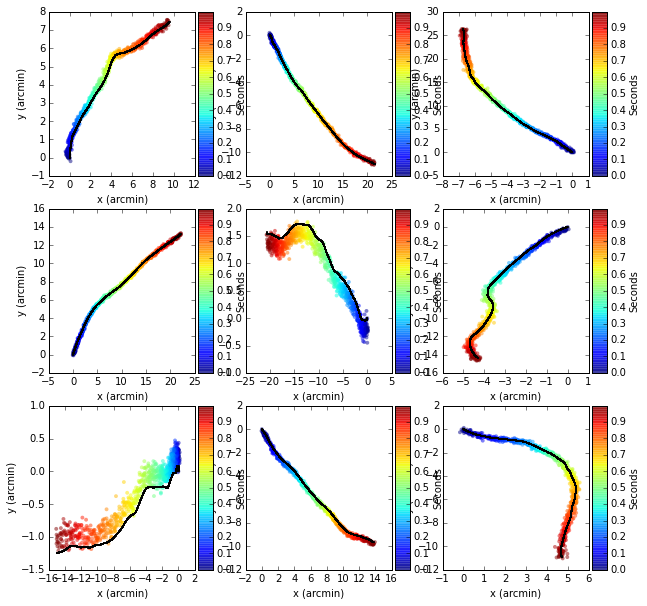

In [44]:
##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(len(gentrials) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = False )

for i, pl in enumerate(ax.flatten()):
    trial = gentrials[i]
    ##plot original data
    #print gentrialm
    imraw = pl.scatter(trial.xraw, trial.yraw, s=15, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #print trial.y
    pl.scatter(trial.x, trial.y, s=1, c='black')

plt.show()

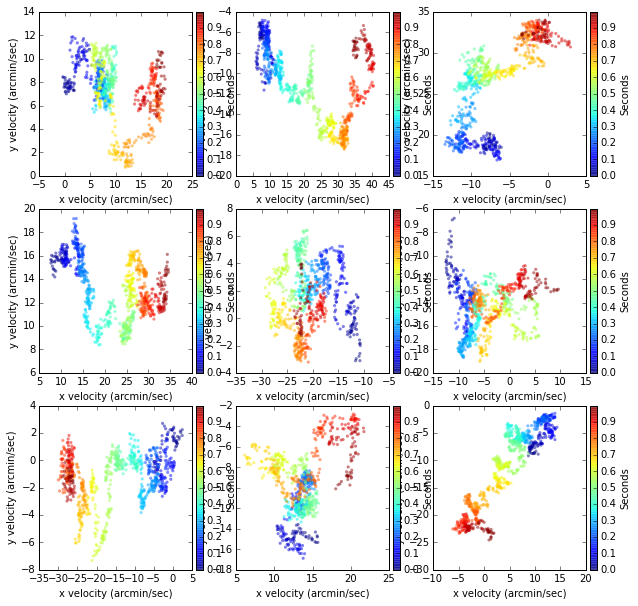

In [45]:
##plot our new results for velocity

##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(len(gentrials) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = gentrials[i]
    ##plot original data
    imraw = pl.scatter(trial.xv, trial.yv, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x velocity (arcmin/sec)')
    pl.set_ylabel('y velocity (arcmin/sec)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')

plt.show()

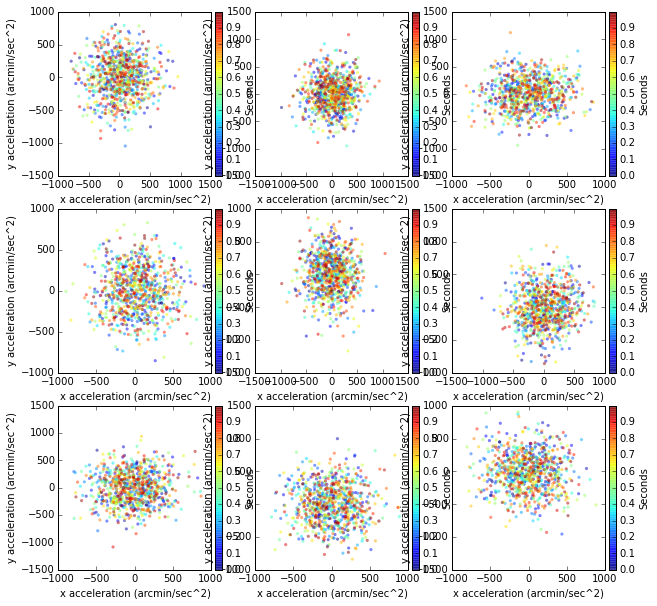

In [46]:
###### plot our new results for acceleration

##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(len(gentrials) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10)) 

for i, pl in enumerate(ax.flatten()):
    trial = gentrials[i]
    ##plot original data
    #imraw = pl.scatter((trial.xv[1:] - trial.xv[:-1]), (trial.yv[1:] - trial.yv[:-1]), s=10, c=trial.time[:-1], cmap=cm.jet, alpha=0.5, edgecolors='none')
    imraw = pl.scatter(trial.xa, trial.ya, s=10, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x acceleration (arcmin/sec^2)')
    pl.set_ylabel('y acceleration (arcmin/sec^2)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #pl.scatter(trial.xv, trial.yv, s=2, c='black')

plt.show()

## Compare Models

We want to find ways to compare our model to others. Lets start by measuring persistant motion, as we did before.

### Brownian Motion Model

In [47]:
from numpy import arange

def gentrialbm(dt, tx, ty, ov):
    
    timesteps = int(1/dt) + 1
    enumerates = arange(0,1,dt)
    states = np.zeros((timesteps,2))
    measurements = np.zeros((timesteps,2))
    
    for t in range(0,timesteps):
    #print timesteps
          
        if t == 0:
            states[t] = [0,0]
            
            measurements[t] = copy.deepcopy(states[t]) + [np.random.normal(0, np.sqrt(ov)),
                                           np.random.normal(0, np.sqrt(ov))
                                          ]

        else:
            states[t] = copy.deepcopy(states[t-1])  + [np.random.normal(0, np.sqrt(tx)),                                                                
                                        np.random.normal(0, np.sqrt(ty))
                                       ]
            
            measurements[t] = copy.deepcopy(states[t]) + [np.random.normal(0, np.sqrt(ov)),
                                           np.random.normal(0, np.sqrt(ov))
                                           ]

            
    ##instance of EyeTrace initiated with EyeTrace(xlocs, ylocs, time, pixelscale, fname)
    trial = EyeTrace(measurements[:,0], measurements[:,1], enumerates, 1, 'generatedtrialBM')
    trial.x = states[:,0]
    trial.y = states[:,1]
    ##interpolate veclotiy from new smoothed position values
    trial.xv = np.concatenate([[copy.deepcopy(trial.x[1]) - copy.deepcopy(trial.x[0])],
                                 copy.deepcopy(trial.x[1:]) - copy.deepcopy(trial.x[:-1])]) * len(trial.time) #in seconds
    trial.yv = np.concatenate([[copy.deepcopy(trial.y[1]) - copy.deepcopy(trial.y[0])],
                                 copy.deepcopy(trial.y[1:]) - copy.deepcopy(trial.y[:-1])]) * len(trial.time) #in seconds


    ##interpolate acceleration from new smoothed values
    trial.xa = np.concatenate([[copy.deepcopy(trial.xv[1]) - copy.deepcopy(trial.xv[0])],
                                 copy.deepcopy(trial.xv[1:]) - copy.deepcopy(trial.xv[:-1])]) * len(trial.time) #in seconds
    trial.ya = np.concatenate([[copy.deepcopy(trial.yv[1]) - copy.deepcopy(trial.yv[0])],
                                 copy.deepcopy(trial.yv[1:]) - copy.deepcopy(trial.yv[:-1])]) * len(trial.time) #in seconds


    return(trial)

#debugging test
#gentrial(ivx, ivy, dt, tvx, tvy, ov)  

In [48]:
mtrial = kftrials[0]
dt = mtrial.kfdt
tx = 1e-1
ty = tx
ov = mtrial.kfov

##generate trials
gentrialsbm = []
for i in range(0,9):
    trial = gentrialbm(dt, tx, ty, ov)
    gentrialsbm.append(trial)

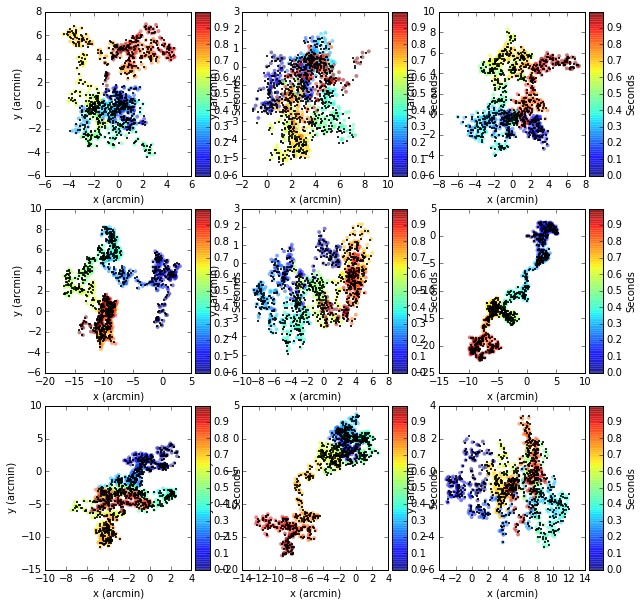

In [49]:
##calc number of rows for ncols
ncol = 3
nrow = int(math.ceil(len(gentrials) / ncol))
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = False )

for i, pl in enumerate(ax.flatten()):
    trial = gentrialsbm[i]
    ##plot original data
    #print gentrialm
    imraw = pl.scatter(trial.xraw, trial.yraw, s=15, c=trial.time, cmap=cm.jet, alpha=0.5, edgecolors='none')
    pl.set_xlabel('x (arcmin)')
    pl.set_ylabel('y (arcmin)')
    #pl.axis('equal') ##comment this in and out
    ##add colorbar
    div = make_axes_locatable(pl)
    cax = div.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(imraw, cax=cax)
    cbar.set_label('Seconds')
    #plot smooth data
    #print trial.y
    pl.scatter(trial.x, trial.y, s=1, c='black')

plt.show()

Changing the values of dx and dy simply change the magnitude of traversal over the trial.

Compare to E&K for simulated data - Velocity first

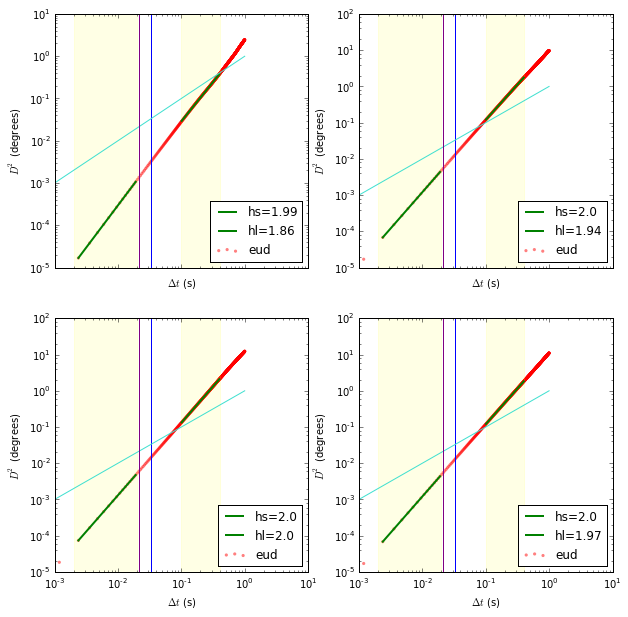

In [52]:
##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(gentrials[0:4]) / ncol))

##calc mean hl and means hs
hs = []
hl = []

##make figures
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = gentrials[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time')
    for m in range(1,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##convert to degrees to compare with paper
    eudist = eudist/60
    
    ##plot x, y, and eud
    #pl.scatter(trial.time, xdist, label= 'x', s=10, alpha=0.5, edgecolors='none', color='blue')
    #pl.scatter(trial.time, ydist, label= 'y', s=10, alpha=0.5, edgecolors='none', color='green')
    pl.scatter(trial.time, eudist, label= 'eud', s=10, alpha=0.5, edgecolors='none', color='red')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    pl.axvspan(0.002, 0.02, alpha=0.1, color='yellow')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(0.1, 0.4, alpha=0.1, color='yellow')

    ##also plot line for scaling exponent H = 1
    #pl.plot(trial.time, trial.time, color='purple')
    
    ##calculate slopes Hs and Hl (at limits from E&K) (Euclidian only)
    ##Hs time 2ms -> 20ms
    hsmask = (trial.time > 0.002) & (trial.time < 0.02)
    hstime = trial.time[hsmask]
    hseudist = eudist[hsmask]
    ##run least square regression of 1st degree on the log-scale values.
    #The equation for a line on a log–log scale would be:
    #log{10}Y = m*log{10}x + b
    #Y = x^m*10^b, 
    #where m is the slope and b is the intercept point on the log plot
    #hslmm, hslmb = np.polyfit(hstime, hseudist, deg=1)
    hslm, hslb = np.polyfit(np.log10(hstime), np.log10(hseudist), deg=1)
    hs.append(hslm)
    #hsmv = np.add(np.multiply(hslm, hstime), hslb)
    hsmv = hstime**hslm*10**hslb
    #hslmp = np.poly1d(hslm) #convenience class for polynomials
    pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslm,2)))     

    #hsmv = np.add(np.multiply(hslmm, hstime), hslmb)
    #pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslmm,2)))     
    ##Hl time 100ms -> 400ms
    hlmask = (trial.time > 0.1) & (trial.time < 0.4)
    hltime = trial.time[hlmask]
    hleudist = eudist[hlmask]
    ##run least square regression of 1st degree
    hllmm, hllmb = np.polyfit(np.log10(hltime), np.log10(hleudist), deg=1)
    hl.append(hllmm)
    #hlmv = np.add(np.multiply(hllmm, hltime), hllmb)
    hlmv = hltime**hllmm*10**hllmb
    pl.plot(hltime, hlmv, color = 'green', linewidth = 2, label = 'hl=%s'%(round(hllmm,2)))
     
    ##plot knee
    pl.axvline(.033, color = 'blue')
    
    ##also plot line for scaling exponent H = 1
    pl.plot(trial.time, trial.time, color='turquoise')
    
    ##plot time to compare one strip to last (41 strips)
    #1/(1920/41) =  0.02135
    pl.axvline(.02135, color = 'purple')
    
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$ (degrees)')
    
    #legend
    pl.legend(loc = 0)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)


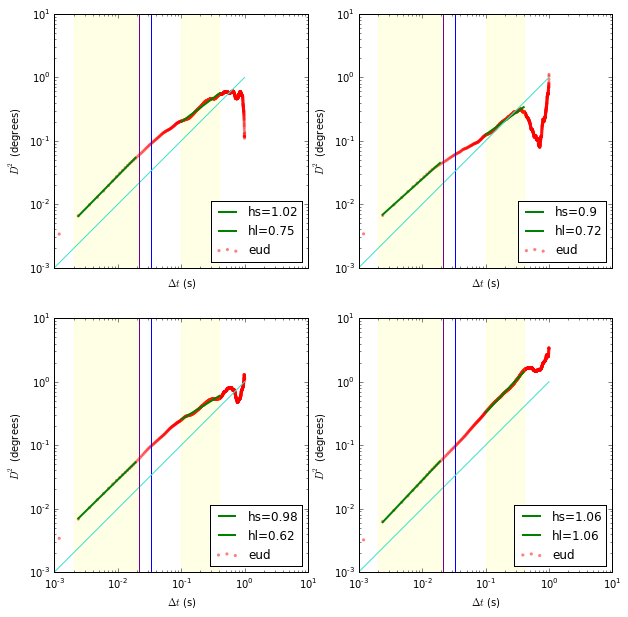

In [53]:
##calc number of rows for ncols
ncol = 2
nrow = int(math.ceil(len(gentrialsbm[0:4]) / ncol))

##calc mean hl and means hs
hs = []
hl = []

##make figures
fig, ax = plt.subplots(nrow, ncol, figsize=(10,10), sharex = True )

##iterate over all trials
for i, pl in enumerate(ax.flatten()):
    trial = gentrialsbm[i]

    ##initiate the numpy arrays that will hold the values we use
    xdist = np.zeros(len(trial.x))
    ydist = np.zeros(len(trial.y))
    assert(len(trial.x)==len(trial.y))
    eudist = np.zeros(len(trial.x))
    
    ##iterate over all values of m (aka'lag time')
    for m in range(1,len(trial.x)):
        
        ##x
        xim = trial.x[m:]
        xi = trial.x[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        xd = np.mean((xim - xi)**2)
        xdist[m] = xd
        
        ##y
        yim = trial.y[m:]
        yi = trial.y[:-m]
        ##we don't have to sum over all values 1-N-m then divide by N-m. Just take the mean instead.
        yd = np.mean((yim - yi)**2)
        ydist[m] = yd
        
        ##euclidian
        ##don't need to calculate square of sqare root (for euclidian dist)
        eud = np.mean(xd + yd) 
        eudist[m] = eud
    
    ##convert to degrees to compare with paper
    eudist = eudist/60
    
    ##plot x, y, and eud
    #pl.scatter(trial.time, xdist, label= 'x', s=10, alpha=0.5, edgecolors='none', color='blue')
    #pl.scatter(trial.time, ydist, label= 'y', s=10, alpha=0.5, edgecolors='none', color='green')
    pl.scatter(trial.time, eudist, label= 'eud', s=10, alpha=0.5, edgecolors='none', color='red')
    
    ##also plot limits in E&K paper
    ##2ms start, 20ms end of Hs < 1
    pl.axvspan(0.002, 0.02, alpha=0.1, color='yellow')
    ##100ms start, 400ms end Hl > 1
    pl.axvspan(0.1, 0.4, alpha=0.1, color='yellow')

    ##also plot line for scaling exponent H = 1
    #pl.plot(trial.time, trial.time, color='purple')
    
    ##calculate slopes Hs and Hl (at limits from E&K) (Euclidian only)
    ##Hs time 2ms -> 20ms
    hsmask = (trial.time > 0.002) & (trial.time < 0.02)
    hstime = trial.time[hsmask]
    hseudist = eudist[hsmask]
    ##run least square regression of 1st degree on the log-scale values.
    #The equation for a line on a log–log scale would be:
    #log{10}Y = m*log{10}x + b
    #Y = x^m*10^b, 
    #where m is the slope and b is the intercept point on the log plot
    #hslmm, hslmb = np.polyfit(hstime, hseudist, deg=1)
    hslm, hslb = np.polyfit(np.log10(hstime), np.log10(hseudist), deg=1)
    hs.append(hslm)
    #hsmv = np.add(np.multiply(hslm, hstime), hslb)
    hsmv = hstime**hslm*10**hslb
    #hslmp = np.poly1d(hslm) #convenience class for polynomials
    pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslm,2)))     

    #hsmv = np.add(np.multiply(hslmm, hstime), hslmb)
    #pl.plot(hstime, hsmv, color = 'green', linewidth = 2, label = 'hs=%s'%(round(hslmm,2)))     
    ##Hl time 100ms -> 400ms
    hlmask = (trial.time > 0.1) & (trial.time < 0.4)
    hltime = trial.time[hlmask]
    hleudist = eudist[hlmask]
    ##run least square regression of 1st degree
    hllmm, hllmb = np.polyfit(np.log10(hltime), np.log10(hleudist), deg=1)
    hl.append(hllmm)
    #hlmv = np.add(np.multiply(hllmm, hltime), hllmb)
    hlmv = hltime**hllmm*10**hllmb
    pl.plot(hltime, hlmv, color = 'green', linewidth = 2, label = 'hl=%s'%(round(hllmm,2)))
     
    ##plot knee
    pl.axvline(.033, color = 'blue')
    
    ##also plot line for scaling exponent H = 1
    pl.plot(trial.time, trial.time, color='turquoise')
    
    ##plot time to compare one strip to last (41 strips)
    #1/(1920/41) =  0.02135
    pl.axvline(.02135, color = 'purple')
    
    ##log scale
    pl.set_xscale('log')
    pl.set_yscale('log')

    ##labels
    pl.set_xlabel('$\Delta t$ (s)')
    pl.set_ylabel('$D^2$ (degrees)')
    
    #legend
    pl.legend(loc = 0)

##extra code for making graphs pretty - don't use now.
#fig.subplots_adjust(hspace=0)a
#plt.setp([a.get_xticklabels() for a in fig.axes[:-2]], visible=False)
